# Reef Net Calcification

This section outlines the prcess for collection and cleaning of data from the eReefs dataset

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import seaborn as sns
import cmocean

%matplotlib inline

First we load a dataset. 

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

In [2]:
#Data set loaded from thredds server

df = xr.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml")
df


<xarray.Dataset>
Dimensions:               (k: 47, j: 180, i: 600, k_sed: 4, time: 1178)
Coordinates:
    zc                    (k) float64 ...
    longitude             (j, i) float64 ...
    latitude              (j, i) float64 ...
    zcsed                 (k_sed) float64 ...
  * time                  (time) datetime64[ns] 2016-11-01T02:00:00 ... 2019-...
Dimensions without coordinates: k, j, i, k_sed
Data variables: (12/305)
    botz                  (j, i) float64 ...
    zc_sedim              (time, k_sed, j, i) float64 ...
    uav                   (time, j, i) float32 ...
    vav                   (time, j, i) float32 ...
    avg_speed             (time, j, i) float32 ...
    avg_dir               (time, j, i) float32 ...
    ...                    ...
    R_510                 (time, j, i) float32 ...
    R_640                 (time, j, i) float32 ...
    R_590                 (time, j, i) float32 ...
    SGH_shear_mort        (time, j, i) float32 ...
    SGD_N_pr              (time, j, i) float32 ...
    SGD_N_gr              (time, j, i) float32 ...
Attributes:
    Run_ID:       2.0
    hasVocab:     1
    title:        GBR4 BGC (Spectral) Transport
    paramhead:    GBR 4km resolution grid
    paramfile:    in.prm
    ems_version:  v1.0 rev(5997)
    Conventions:  CF-1.0

## Variable selection

Here we select the necesary variables from the larger dataset for our model

In [3]:
ds = df[[ 'temp', 'Gnet', 'PH', 'botz']]
ds

<xarray.Dataset>
Dimensions:    (time: 1178, k: 47, j: 180, i: 600)
Coordinates:
    zc         (k) float64 -3.89e+03 -3.68e+03 -3.48e+03 ... -0.5 0.5 1.5
    longitude  (j, i) float64 ...
    latitude   (j, i) float64 ...
  * time       (time) datetime64[ns] 2016-11-01T02:00:00 ... 2019-11-28T02:00:00
Dimensions without coordinates: k, j, i
Data variables:
    temp       (time, k, j, i) float32 ...
    Gnet       (time, j, i) float32 ...
    PH         (time, k, j, i) float32 ...
    botz       (j, i) float64 ...
Attributes:
    Run_ID:       2.0
    hasVocab:     1
    title:        GBR4 BGC (Spectral) Transport
    paramhead:    GBR 4km resolution grid
    paramfile:    in.prm
    ems_version:  v1.0 rev(5997)
    Conventions:  CF-1.0

Identify the spatial limits of the coordinates

In [22]:
print(' model spatial extent:\n')
print(' - Longitudinal extent:',np.nanmin(ds['longitude']),np.nanmax(ds['longitude']))
print(' - Latitudinal extent:',np.nanmin(ds['latitude']),np.nanmax(ds['latitude']))


 model spatial extent:

 - Longitudinal extent: 0.0 156.8856378
 - Latitudinal extent: -28.6960218 0.0


In [5]:
# Removing non-finite values
ds.latitude.values = np.nan_to_num(ds.latitude.values)
ds.longitude.values = np.nan_to_num(ds.longitude.values)

# Check the arrays shapes
print(ds.longitude)

<xarray.DataArray 'longitude' (j: 180, i: 600)>
array([[142.168788 , 142.1804468, 142.19211  , ...,   0.       ,
          0.       ,   0.       ],
       [142.2013204, 142.2123752, 142.2236158, ...,   0.       ,
          0.       ,   0.       ],
       [142.2333969, 142.2441535, 142.25509  , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [147.8135068, 147.8142988, 147.8153794, ..., 156.8042355,
        156.8051407, 156.8061819],
       [147.8353694, 147.8363158, 147.8375886, ..., 156.84433  ,
        156.8451114, 156.8460513],
       [147.8566896, 147.8580363, 147.8596273, ..., 156.8843511,
        156.8849406, 156.8856378]])
Coordinates:
    longitude  (j, i) float64 142.2 142.2 142.2 142.2 ... 156.9 156.9 156.9
    latitude   (j, i) float64 -8.074 -8.107 -8.139 ... -28.52 -28.56 -28.59
Dimensions without coordinates: j, i
Attributes:
    standard_name:    longitude
    long_name:        Longitude
    units:            degrees_east
    coordinate_type:  long

In [6]:
# Mask nans
lat = ma.masked_invalid(ds.latitude.values)
lon = ma.masked_invalid(ds.longitude.values)

# Check the arrays shapes
print(lon.shape,lat.shape)


(180, 600) (180, 600)


# Reef Selection

Next we select the reef of interest within the bounds of the GBR

In [7]:

## Northern Reefs ##
#Davies Reef
# reeflat, reeflon = -18.823797, 147.637696

#Yule Reef
# reeflat, reeflon = -11.949075, 143.985203

# key Reef
# reeflat, reeflon = -12.228707, 143.279144


## Southern Reefs ##
#Heron Reef 
reeflat, reeflon = -23.450571, 151.950123

We need to make sure the coordinates we provide are trnaslated to the data wee have and so we code to recieve the closest corresponding point

In [8]:
# Find the closest point base on the coordinates (lon, lat) we can do that a bit better with a kd-tree if you want
# to analyse multiple reefs
j_idx, i_idx = np.where((np.abs(lat-reeflat)<0.02)&(np.abs(lon-reeflon)<0.02))
j_reef = j_idx[0]
i_reef = i_idx[0]



In [9]:
# Checking the returned i,j index:
print('Reef lon position ',reeflon,' Found closest lon position in the data ',lon[j_reef,i_reef])
print('Reef lat position ',reeflat,' Found closest lat position in the data ',lat[j_reef,i_reef])


Reef lon position  151.950123  Found closest lon position in the data  151.9327198
Reef lat position  -23.450571  Found closest lat position in the data  -23.4408406


Now that we have the position (j,i) in the dataset we can extract the variables at this specific location and depth (-1.5 m):

In [10]:
reef_Gnet = ds.sel(k=(43))
reef_Gnet = reef_Gnet.sel(j=j_reef, i=i_reef).drop_vars({'longitude','latitude', 'botz', 'zc'})
reef_Gnet


<xarray.Dataset>
Dimensions:  (time: 1178)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-01T02:00:00 ... 2019-11-28T02:00:00
Data variables:
    temp     (time) float32 ...
    Gnet     (time) float32 ...
    PH       (time) float32 ...
Attributes:
    Run_ID:       2.0
    hasVocab:     1
    title:        GBR4 BGC (Spectral) Transport
    paramhead:    GBR 4km resolution grid
    paramfile:    in.prm
    ems_version:  v1.0 rev(5997)
    Conventions:  CF-1.0

There needs to be some final data cleaning due to duplicates in the time series

In [11]:
# step 1
reef_Gnet["time"] = reef_Gnet["time"].dt.floor("D")

# step 2
val,idx = np.unique(reef_Gnet.time, return_index=True)
reef_Gnet = reef_Gnet.isel(time=idx)

By querying the min/max net calcification we can confirm that point selected has calcification Data

In [12]:
print(' model Gnet limits:\n')
print(' - Gnet min/max:',np.nanmin(reef_Gnet['Gnet']),np.nanmax(reef_Gnet['Gnet']))


 model Gnet limits:

 - Gnet min/max: 0.024382103 0.033046875


Summary plots to assess the validity of data obtained

Text(0.5, 1.0, 'Gnet Versus pH')

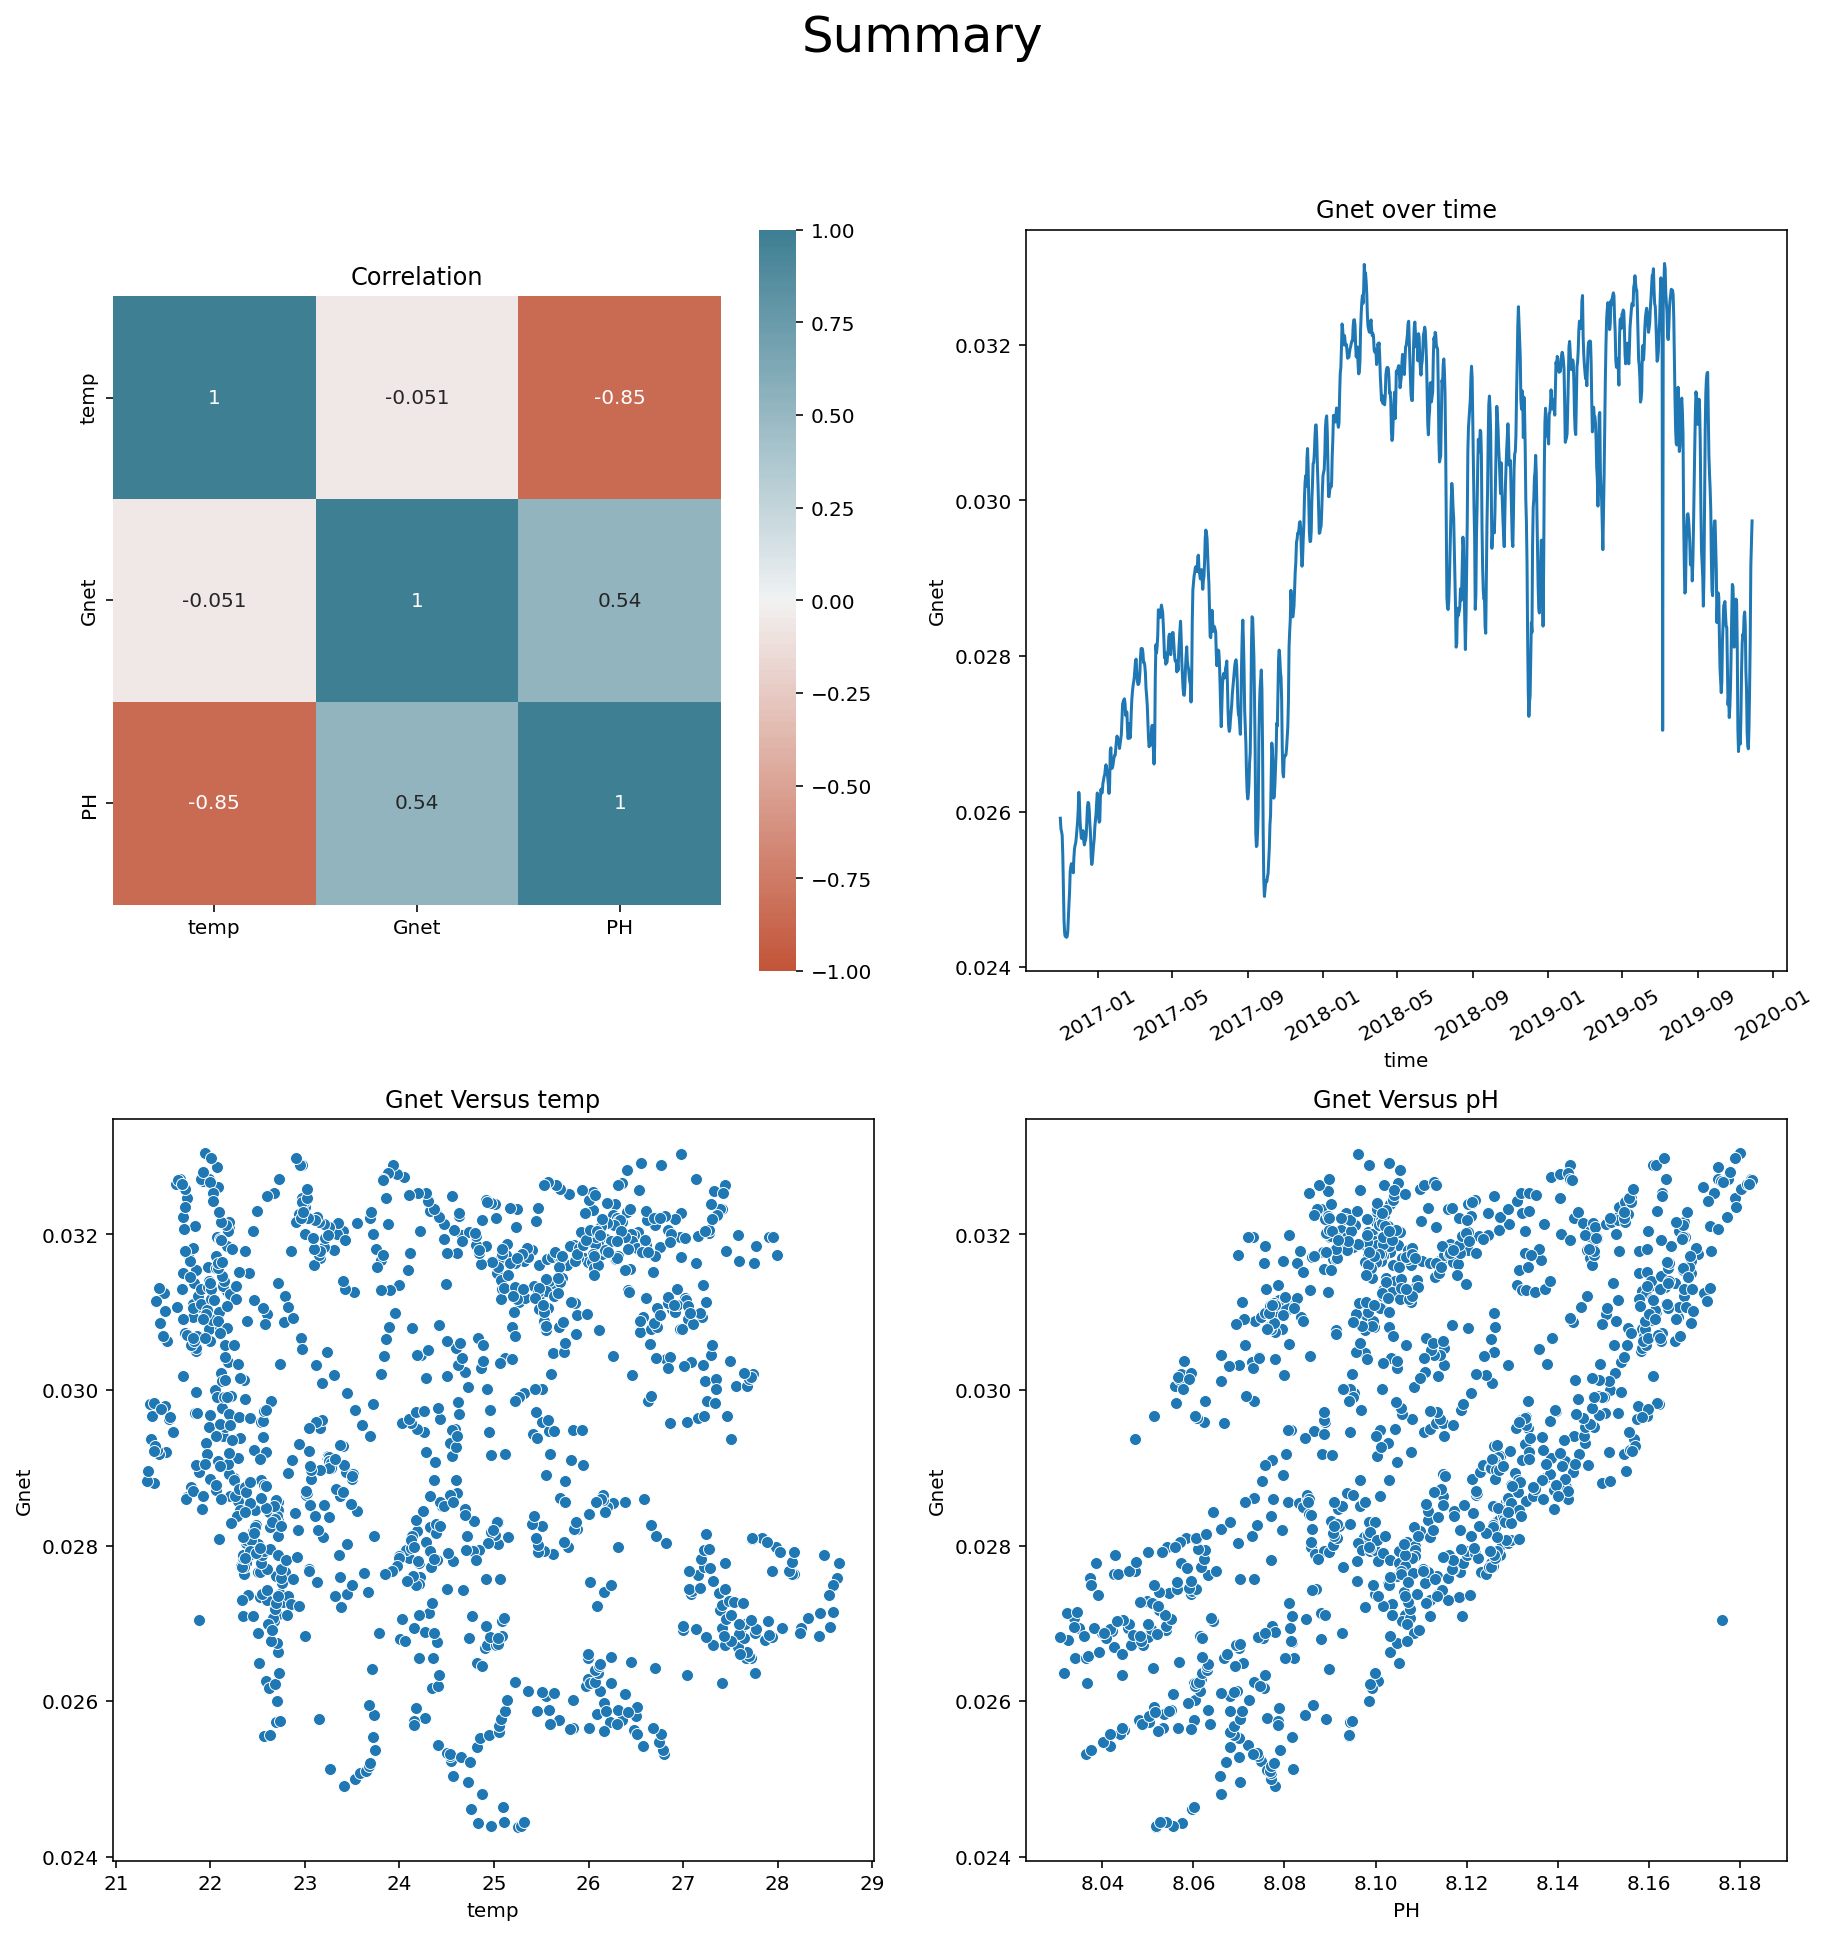

In [13]:
reef_Gnet_pd = reef_Gnet.to_dataframe()
fig, axes = plt.subplots(2,2,figsize=(15,15))

corr = reef_Gnet_pd.corr()

sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True, ax= axes[0,0])

ax = sns.lineplot(data=reef_Gnet_pd, x='time', y='Gnet',ax= axes[0,1]) 
axes[0,1].tick_params(axis='x', labelrotation=30)


sns.scatterplot(data = reef_Gnet_pd, x='PH',y='Gnet',ax= axes[1,1])
sns.scatterplot(data = reef_Gnet_pd, x='temp',y='Gnet',ax= axes[1,0])

plt.suptitle("Summary", fontsize=25)
axes[0,0].set_title('Correlation')
axes[0,1].set_title('Gnet over time')
axes[1,0].set_title('Gnet Versus temp')
axes[1,1].set_title('Gnet Versus pH')


Now that the data has been checked it can be saved into the reefs data file.

In [14]:
# reef_Gnet.to_netcdf('Reef-Data/Heron_reef.nc')

Now that we have confirmed the above process provides the required data we can create a function in order to expedite the process of collecting Gnet data for each reef

In [15]:
def Gnet_data(reef_lat, reef_lon):

    '''
    This funtion collects and cleans data from the eReefs netCDF
    file available on the AIMS OpenDAP server.
    
    https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml
    
    args:
    
    - reef_lat : latitudinal coordinate of reef location
    - reef_lon : longitudinal coordinate of reef location
    '''
    
    # Required packages for function.
    import numpy as np
    import numpy.ma as ma
    import pandas as pd
    import xarray as xr

    from matplotlib import pyplot as plt
    %config InlineBackend.figure_format = 'retina'
    plt.ion()  # To trigger the interactive inline mode

    import seaborn as sns
    import cmocean

    %matplotlib inline

    # First we load a dataset. 

    # Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:
    df = xr.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml")
    df


    # Variable selection

    # Here we select the necesary variables from the larger dataset for our model

    ds = df[[ 'temp', 'Gnet', 'PH', 'botz']]
    ds

    print(' model spatial extent:\n')
    print(' - Longitudinal extent:',np.nanmin(ds['longitude']),np.nanmax(ds['longitude']))
    print(' - Latitudinal extent:',np.nanmin(ds['latitude']),np.nanmax(ds['latitude']))


    # Removing non-finite values
    ds.latitude.values = np.nan_to_num(ds.latitude.values)
    ds.longitude.values = np.nan_to_num(ds.longitude.values)

    # Mask nans
    lat = ma.masked_invalid(ds.latitude.values)
    lon = ma.masked_invalid(ds.longitude.values)


    # Reef Selection
    # Next we select the reef of interest within the bounds of the GBR

    reeflat, reeflon = reef_lat, reef_lon

    #We need to make sure the coordinates we provide are trnaslated to the data wee have and so we code to recieve the closest corresponding point

    # Find the closest point base on the coordinates (lon, lat) we can do that a bit better with a kd-tree if you want
    # to analyse multiple reefs
    j_idx, i_idx = np.where((np.abs(lat-reeflat)<0.02)&(np.abs(lon-reeflon)<0.02))
    j_reef = j_idx[0]
    i_reef = i_idx[0]



    # Checking the returned i,j index:
    print(' Closest data point found to input coordinates:\n')
    print(' - Reef lon position ',reeflon,' Found closest lon position in the data ',lon[j_reef,i_reef])
    print(' - Reef lat position ',reeflat,' Found closest lat position in the data ',lat[j_reef,i_reef])


    # Now that we have the position (j,i) in the dataset we can extract the variables at this specific location:

    reef_Gnet = ds.sel(k=(43))
    reef_Gnet = reef_Gnet.sel(j=j_reef, i=i_reef).drop_vars({'longitude','latitude', 'botz', 'zc'})
    reef_Gnet


    # There needs to be some final data cleaning due to duplicates in the time series

    # step 1
    reef_Gnet["time"] = reef_Gnet["time"].dt.floor("D")

    # step 2
    val,idx = np.unique(reef_Gnet.time, return_index=True)
    reef_Gnet = reef_Gnet.isel(time=idx)

    # By querying the min/max net calcification we can confirm that point selected has calcification Data

    print(' model Gnet limits:\n')
    print(' - Gnet min/max:',np.nanmin(reef_Gnet['Gnet']),np.nanmax(reef_Gnet['Gnet']))


    # Summary plots to assess the validity of data obtained

    reef_Gnet_pd = reef_Gnet.to_dataframe()
    fig, axes = plt.subplots(2,2,figsize=(15,15))

    corr = reef_Gnet_pd.corr()

    sns.heatmap(corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, annot=True, ax= axes[0,0])

    ax = sns.lineplot(data=reef_Gnet_pd, x='time', y='Gnet',ax= axes[0,1]) 
    axes[0,1].tick_params(axis='x', labelrotation=30)


    sns.scatterplot(data = reef_Gnet_pd, x='PH',y='Gnet',ax= axes[1,1])
    sns.scatterplot(data = reef_Gnet_pd, x='temp',y='Gnet',ax= axes[1,0])

    plt.suptitle("Summary", fontsize=25)
    axes[0,0].set_title('Correlation')
    axes[0,1].set_title('Gnet over time')
    axes[1,0].set_title('Gnet Versus temp')
    axes[1,1].set_title('Gnet Versus pH')
    
    return reef_Gnet

 model spatial extent:

 - Longitudinal extent: 142.168788 156.8856378
 - Latitudinal extent: -28.6960218 -7.0119082
 Closest data point found to input coordinates:

 - Reef lon position  145.456289  Found closest lon position in the data  145.4612374
 - Reef lat position  -14.690479  Found closest lat position in the data  -14.7059836
 model Gnet limits:

 - Gnet min/max: -0.002182611 0.033442985


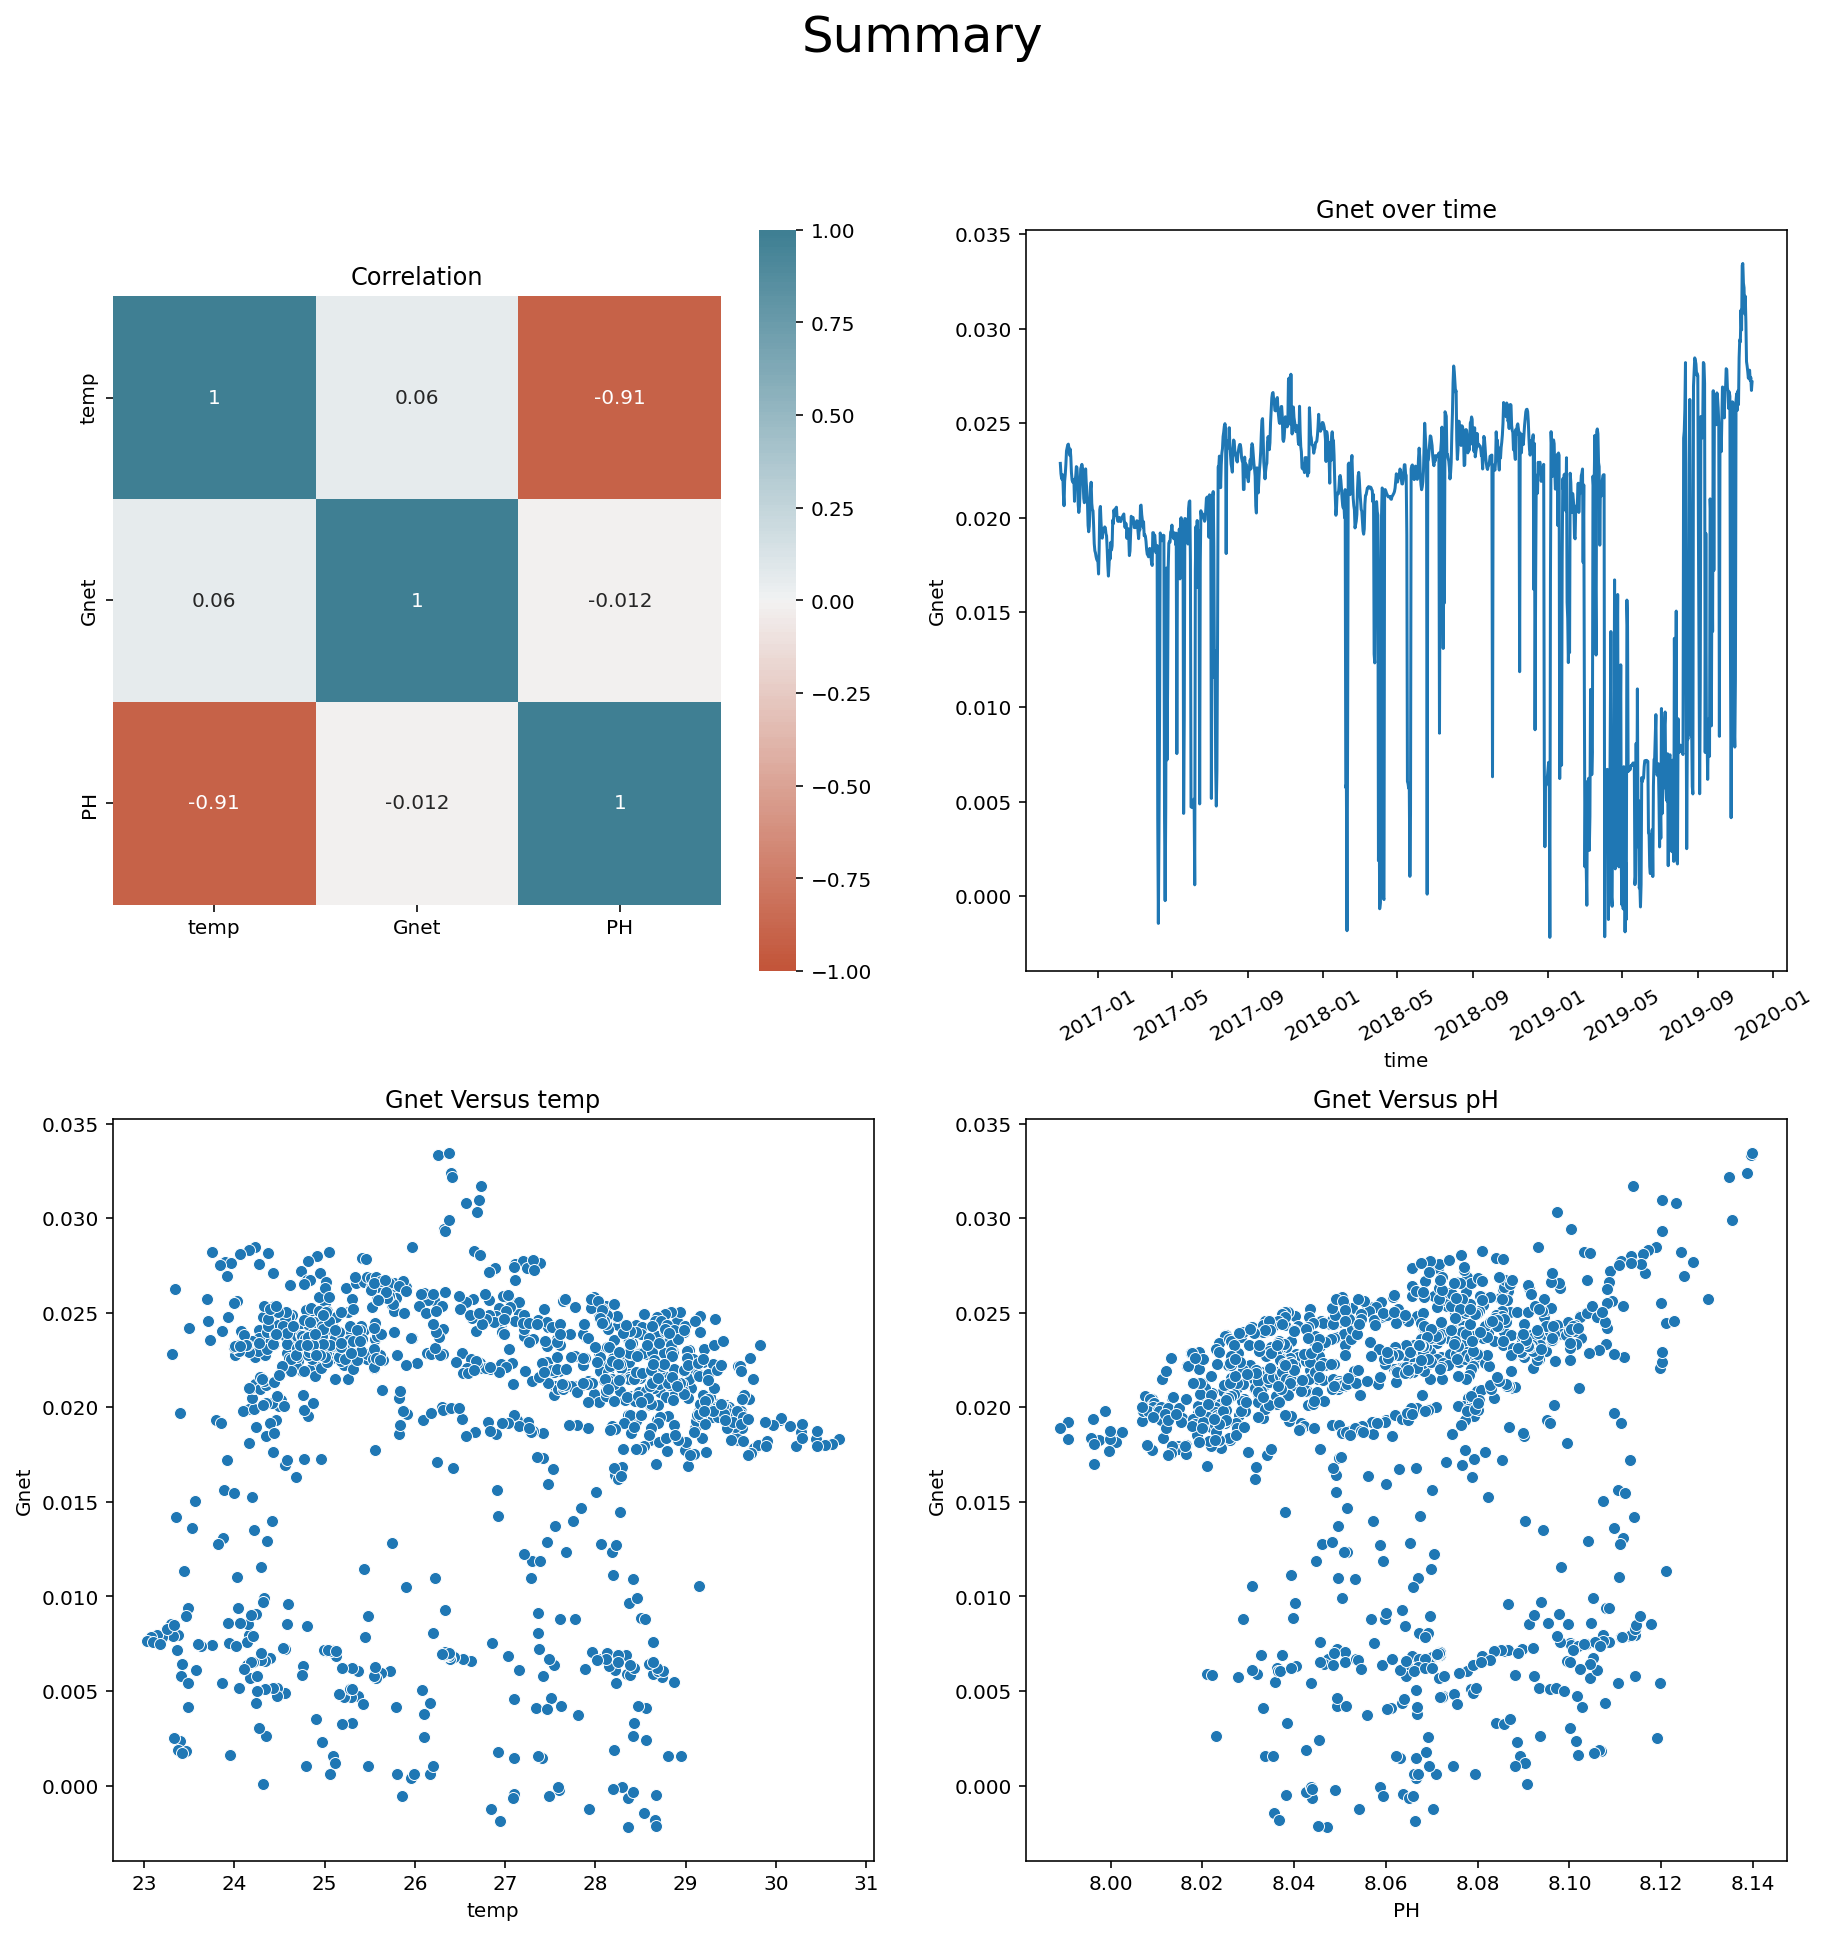

In [16]:
Reef_Gnet = Gnet_data(-14.690479, 145.456289)

In [17]:
Reef_Gnet

<xarray.Dataset>
Dimensions:  (time: 1122)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-01 2016-11-02 ... 2019-11-28
Data variables:
    temp     (time) float32 26.52 26.72 26.74 26.83 ... 27.32 27.1 27.11 26.82
    Gnet     (time) float32 0.02288 0.02233 0.0221 ... 0.02741 0.02673 0.02718
    PH       (time) float32 8.06 8.066 8.063 8.062 ... 8.077 8.077 8.072 8.069
Attributes:
    Run_ID:       2.0
    hasVocab:     1
    title:        GBR4 BGC (Spectral) Transport
    paramhead:    GBR 4km resolution grid
    paramfile:    in.prm
    ems_version:  v1.0 rev(5997)
    Conventions:  CF-1.0

In [18]:
# Reef_Gnet.to_netcdf('Reef-Data/Lizard_island_reef.nc')

Now that we have created the function and stored in in a .py file we can call it to continue sourcing reef data

In [19]:
import Functions
from Functions import Gnet_data

%matplotlib inline

 model spatial extent:

 - Longitudinal extent: 142.168788 156.8856378
 - Latitudinal extent: -28.6960218 -7.0119082
 Closest data poin found to input coordinates:

 - Reef lon position  146.386063  Found closest lon position in the data  146.3727106
 - Reef lat position  -17.534715  Found closest lat position in the data  -17.5478923
 model Gnet limits:

 - Gnet min/max: -0.0021037736 0.027074242


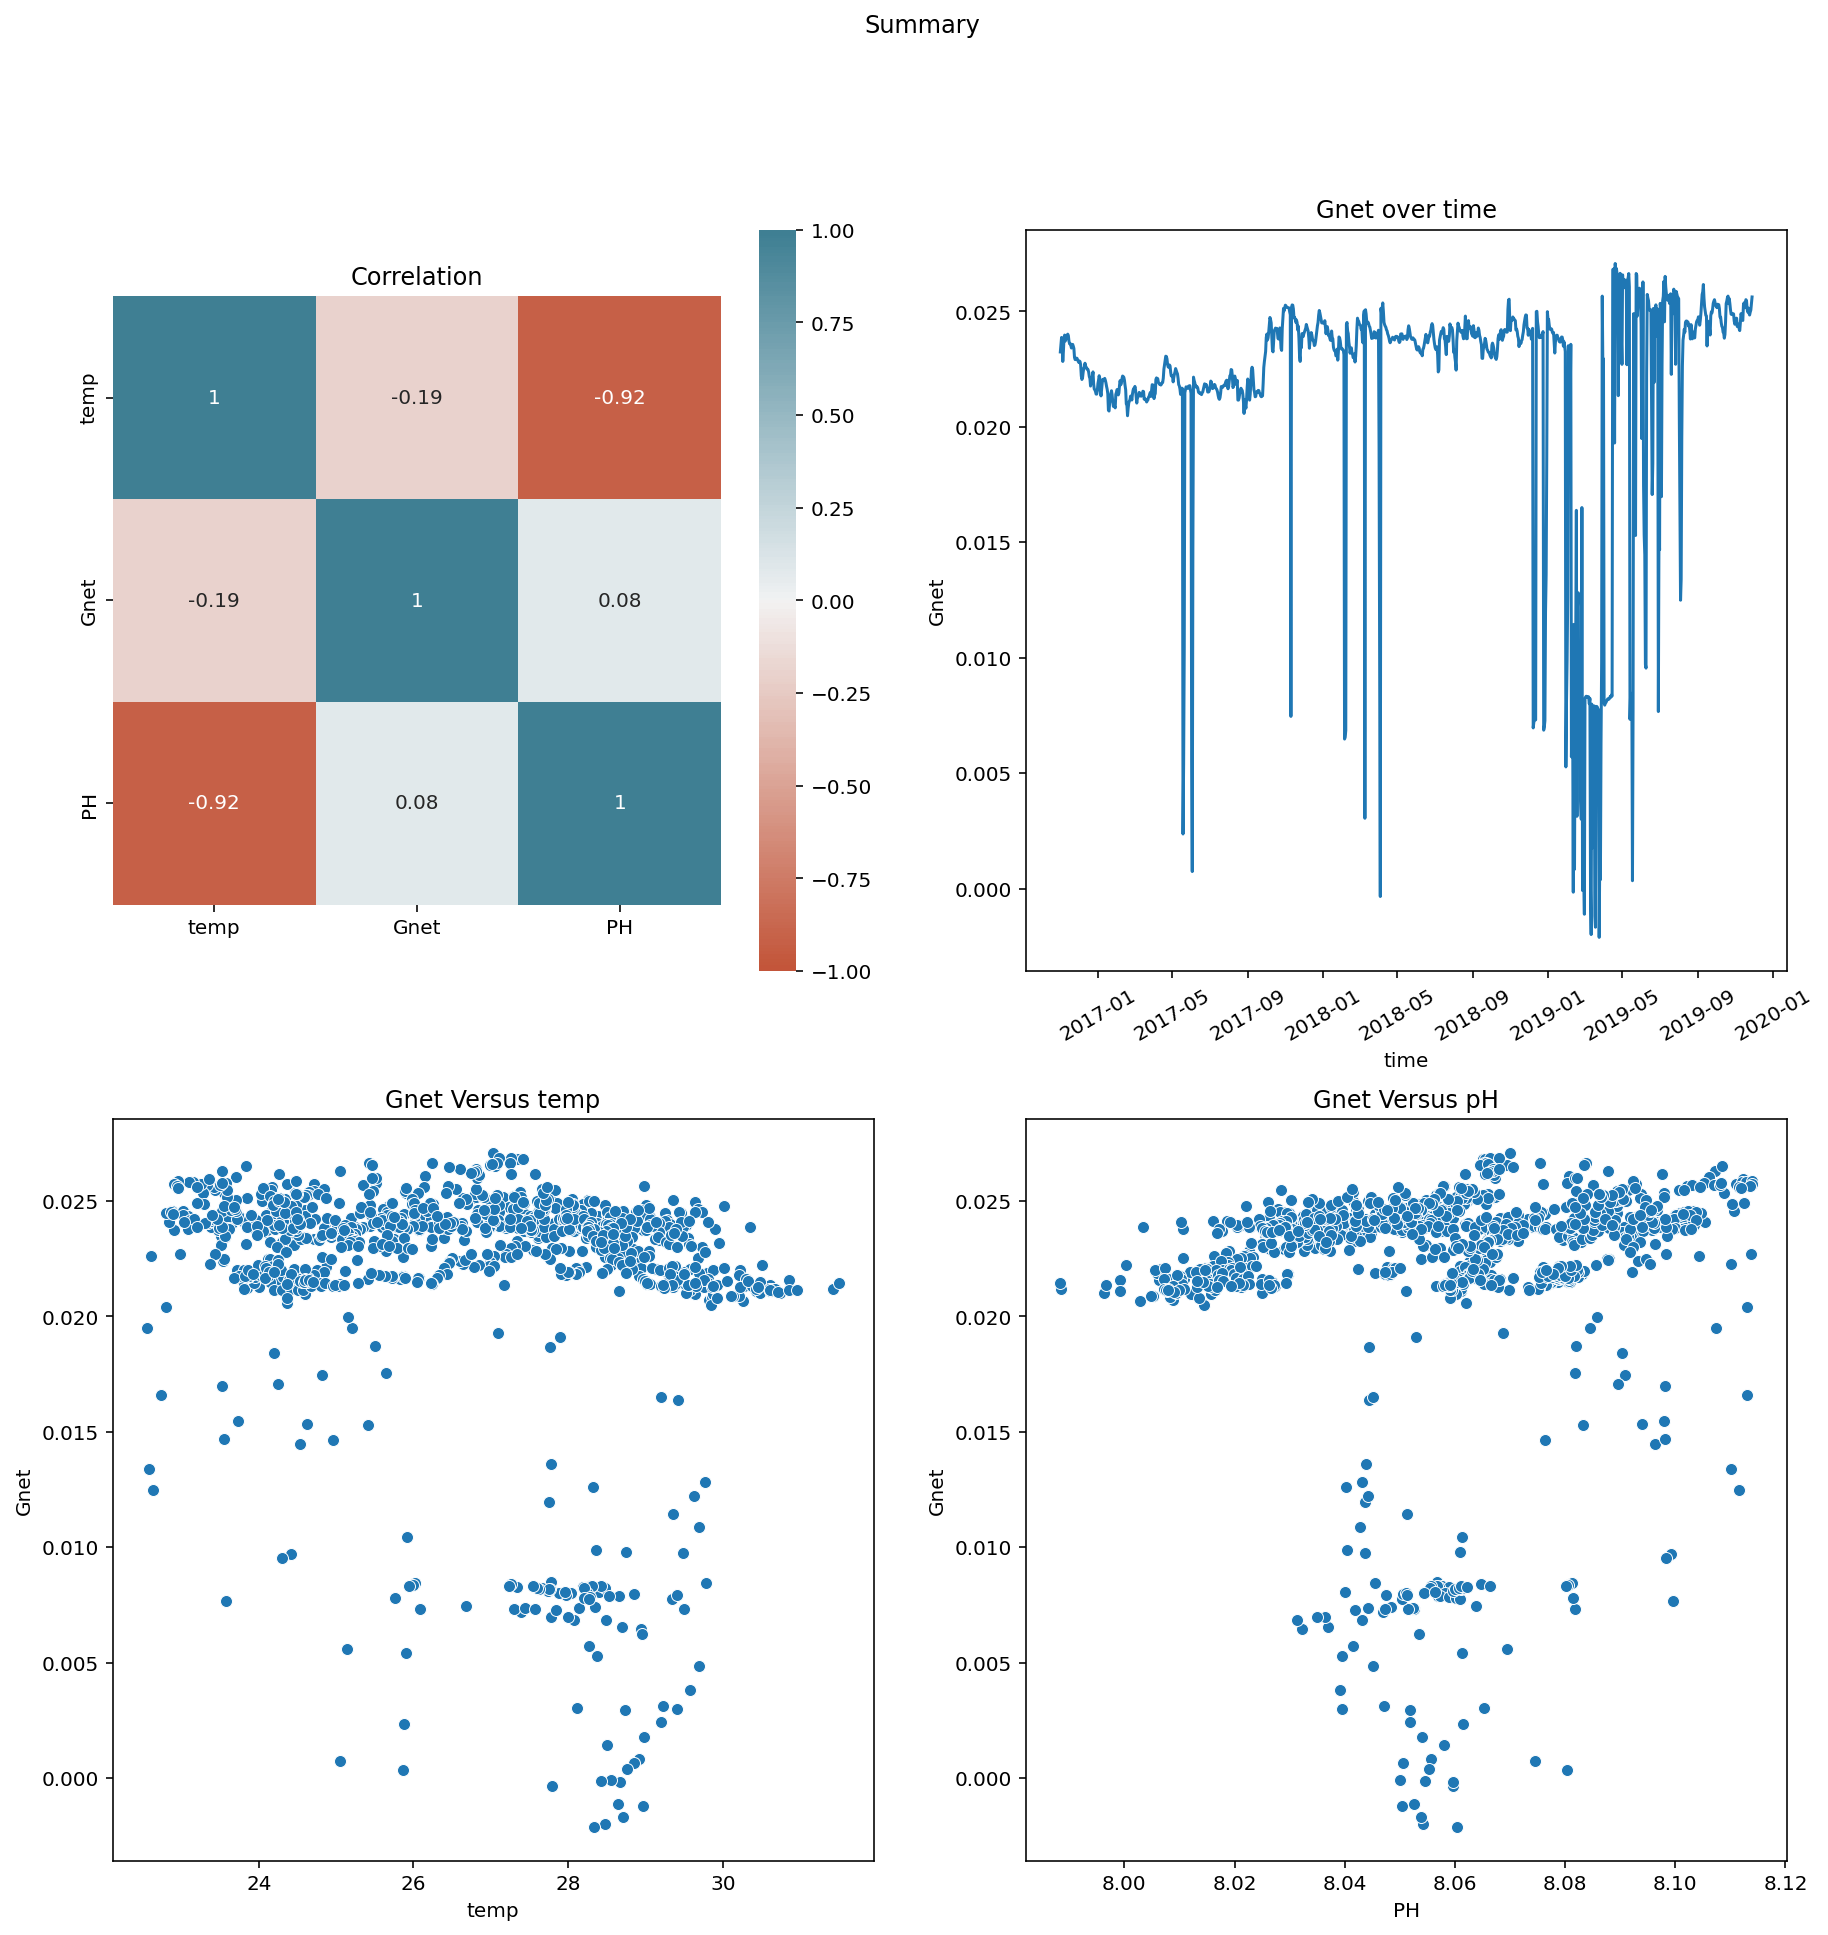

In [20]:
Reef_Gnet= Gnet_data(-17.534715, 146.386063)